Start with something simple, 2D, and only slightly nongaussian. The first will be a parabola-shaped gaussian-based pdf.

In [25]:
!pip install cobaya
!pip install lmfit

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [26]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

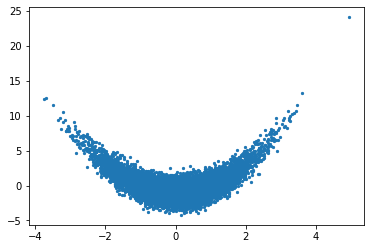

In [27]:
# Sample from the initial distribution
nsamples=10000
X_para = np.random.normal(0, 1, nsamples) 
Y_para = np.random.normal(X_para**2-1,1,nsamples)

plt.scatter(X_para,Y_para,s=5)

Now to set up the MADE.


In [28]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution_para = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution_para.log_prob(x_)
model_para = tfk.Model(x_, log_prob_)

model_para.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata_para = np.stack([X_para, Y_para], axis=-1)
ydata_para = base_distribution.sample(nsamples)

batch_size = 100
model_para.fit(x=xdata_para,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
50/50 [==============================] - 1s 8ms/step - loss: 3.4391 - val_loss: 3.4092
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 3.4166 - val_loss: 3.4076
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 3.3871 - val_loss: 3.4071
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 3.4331 - val_loss: 3.4078
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 3.4585 - val_loss: 3.4084
Epoch 6/100
50/50 [==============================] - 0s 8ms/step - loss: 3.3712 - val_loss: 3.4062
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 3.4239 - val_loss: 3.4066
Epoch 8/100
50/50 [==============================] - 0s 9ms/step - loss: 3.3934 - val_loss: 3.4056
Epoch 9/100
50/50 [==============================] - 0s 8ms/step - loss: 3.4387 - val_loss: 3.4052
Epoch 10/100
50/50 [==============================] - 0s 9ms/step - loss: 3.3831 - val_loss: 3.4044
Epoch 11/

Looks pretty Gausian! Now lets apply a fit, determine the full gaussian map, and plot some contours.

(array([[  0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   2.,   3.,   3.,   7.,   5.,   1.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   6.,  11.,  17.,  20.,   6.,   6.,   4.,
           0.,   0.,   0.],
        [  0.,   2.,   2.,  15.,  18.,  60.,  76.,  66.,  50.,  22.,  11.,
           1.,   0.,   0.],
        [  0.,   2.,   7.,  29.,  75., 121., 190., 206., 144.,  57.,  32.,
          11.,   2.,   0.],
        [  0.,   5.,   8.,  54., 160., 262., 371., 353., 254., 130.,  50.,
          16.,   3.,   0.],
        [  0.,   6.,  24.,  64., 181., 329., 468., 455., 346., 175.,  60.,
          20.,   3.,   1.],
        [  0.,   2.,  11.,  63., 175., 340., 466., 472., 342., 176.,  61.,
          18.,   2.,   1.],
        [  0.,   1.,  15.,  46., 115., 235., 308., 340., 261., 125.,  48.,
          13.,   2.,   0.],
        [  0.,   1.,   7.,  25.,  72., 129., 176., 173., 150.,  77.,  29.

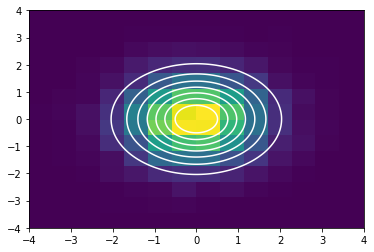

In [29]:
from scipy.stats import multivariate_normal

#sample from learned distribution and map to gaussian space
xy = target_distribution_para.sample(10000)
xy = target_distribution_para.bijector.inverse(xy)
x = xy[...,0]
y = xy[...,1]

# Lets see how this lines up with a perfect gaussian

dist_x, dist_y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((dist_x, dist_y))

rv = multivariate_normal([0., 0.], [[1.0, 0.], [0., 1.0]])

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contour(dist_x, dist_y, rv.pdf(pos),colors='w')
ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

In [30]:
'''
Here what I am doing is finding values to perform the fit. I can start with using the previous histgram and using
a midpoint approximation.
'''

#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
results = np.stack(ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[0])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2])
binx=[]
biny=[]
edge_x = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[1]
edge_y = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
#bins.append(binx)
#bins.append(biny)
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])
        
#print(xvals)
#print(yvals)
#print(z)

In [31]:
# Instead of relying on a perfect gaussian, instead I will perform a fit so that We can see where the loss 
# comes from. Ideally will have mean=(0,0) and cov=diag(1,1)

# Thanks https://stackoverflow.com/questions/52148141/2d-gaussian-fit-using-lmfit 
# since it has been so long since I used lmfit

from lmfit import Parameters, minimize, report_fit

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

initial = Parameters()
initial.add("height",value=1.)
initial.add("centroid_x",value=0.)
initial.add("centroid_y",value=0.)
initial.add("sigma_x",value=1.)
initial.add("sigma_y",value=1.)

fit = minimize(residuals, initial, args=(xvals,yvals, z))
print(report_fit(fit))

# need to implement a covariance term in the model

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 169
    # variables        = 5
    chi-square         = 5750.90547
    reduced chi-square = 35.0664968
    Akaike info crit   = 606.099146
    Bayesian info crit = 621.748639
[[Variables]]
    height:      507.358738 +/- 2.66336097 (0.52%) (init = 1)
    centroid_x: -0.03254472 +/- 0.00536903 (16.50%) (init = 0)
    centroid_y:  0.00642352 +/- 0.00527445 (82.11%) (init = 0)
    sigma_x:     1.02279833 +/- 0.00536944 (0.52%) (init = 1)
    sigma_y:     1.00478500 +/- 0.00527479 (0.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(height, sigma_x) = -0.500
    C(height, sigma_y) = -0.500
None


(array([[  0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   2.,   3.,   3.,   7.,   5.,   1.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   6.,  11.,  17.,  20.,   6.,   6.,   4.,
           0.,   0.,   0.],
        [  0.,   2.,   2.,  15.,  18.,  60.,  76.,  66.,  50.,  22.,  11.,
           1.,   0.,   0.],
        [  0.,   2.,   7.,  29.,  75., 121., 190., 206., 144.,  57.,  32.,
          11.,   2.,   0.],
        [  0.,   5.,   8.,  54., 160., 262., 371., 353., 254., 130.,  50.,
          16.,   3.,   0.],
        [  0.,   6.,  24.,  64., 181., 329., 468., 455., 346., 175.,  60.,
          20.,   3.,   1.],
        [  0.,   2.,  11.,  63., 175., 340., 466., 472., 342., 176.,  61.,
          18.,   2.,   1.],
        [  0.,   1.,  15.,  46., 115., 235., 308., 340., 261., 125.,  48.,
          13.,   2.,   0.],
        [  0.,   1.,   7.,  25.,  72., 129., 176., 173., 150.,  77.,  29.

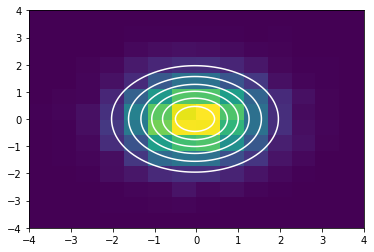

In [32]:
# Now plot the fit over the histogram
Xvals = np.linspace(-4,4,100)
Yvals = np.linspace(-4,4,100)
Xvals,Yvals = np.meshgrid(Xvals, Yvals)

xo = fit.params["centroid_x"].value
yo = fit.params["centroid_y"].value
sx = fit.params["sigma_x"].value
sy = fit.params["sigma_y"].value

Z=gaussian2D(Xvals,Yvals,xo,yo,sx,sy)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

Now lets check the fit. I will first sample from the original distribution (the parabola shape) and map it to the gaussian space. Then I will sample from the gaussian and map it to the parabola. Hopefully these line up somewhat well.

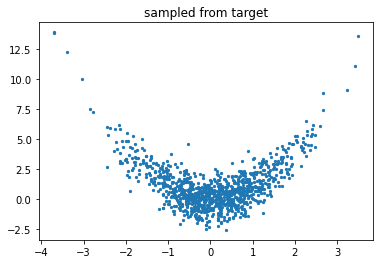

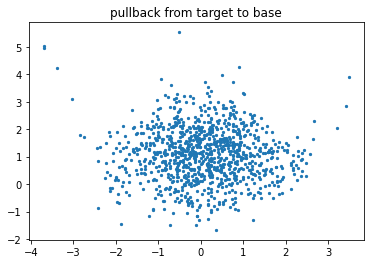

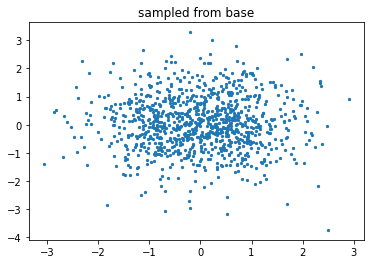

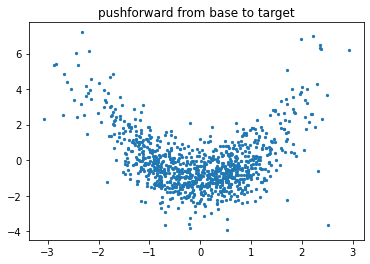

In [33]:
'''
1. Sample from original distribution
2. pull back from the original to the gaussian using the NN bijector inverse
3. sample from gaussian
4. push forward from the gaussian to the original using NN bijector
'''

# resample from target distribution
X = np.random.normal(0, 1, 1000) 
Y = np.random.normal(X**2,1,1000)

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution_para.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution_para.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

Cool! Lets take a look at the contours. I will first find contours on the gaussian and map them to the parabolic distribution.

In [34]:
# Evaluate fit on gaussian, pushforward to find contours

x_points , y_points = np.mgrid[-3:3:.05, -3:3:.05]
xy_points = np.stack((x_points, y_points),axis=-1)
print(x_points)
print(y_points)
z_vals=gaussian2D(x_points,y_points,xo,yo,sx,sy)
x_pos=[]
y_pos=[]

#for i in range(len(x_points)):
#    for j in range(len(y_points)):
#        pos=xy_points[i][j]
#        z_vals.append(gaussian2D(pos[0],pos[1],xo,yo,sx,sy))
#        append to list to use when evaluating NN model
#        x_pos.append(pos[0])
#        y_pos.append(pos[1])

# pushforward points to target distribution
contour_pushforward = target_distribution_para.bijector.forward(tf.cast(xy_points,tf.float32))

contour_x = contour_pushforward[...,0].numpy()
contour_y = contour_pushforward[...,1].numpy()
    
#np.stack((contour_x,contour_y),axis=-1)
#print(contour_x)
#print(contour_y)

[[-3.   -3.   -3.   ... -3.   -3.   -3.  ]
 [-2.95 -2.95 -2.95 ... -2.95 -2.95 -2.95]
 [-2.9  -2.9  -2.9  ... -2.9  -2.9  -2.9 ]
 ...
 [ 2.85  2.85  2.85 ...  2.85  2.85  2.85]
 [ 2.9   2.9   2.9  ...  2.9   2.9   2.9 ]
 [ 2.95  2.95  2.95 ...  2.95  2.95  2.95]]
[[-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 ...
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]]


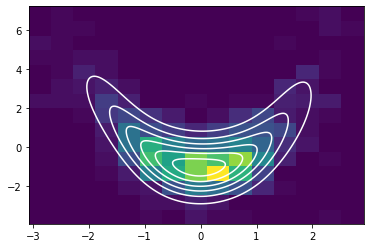

In [35]:
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')

What we want is the contour that passes through the origin. We can find this by finding the probability $P(0)$

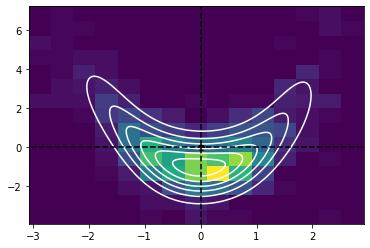

In [36]:
## Add a visualization for the origin

fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')
ax.plot([0,0],[-4,10],color='k',linestyle='dashed')
ax.plot([-5,5],[0,0],color='k',linestyle='dashed')
ax.scatter(0,0,color='k')

tf.Tensor([-0.00338277  1.1060315 ], shape=(2,), dtype=float32)


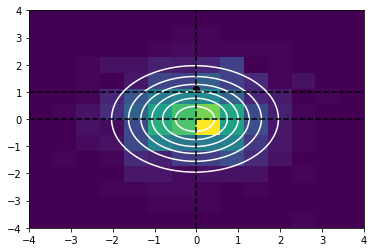

In [37]:
# Visualize what happens to the origin in the original parameter space under the pullback

origin_pullback = target_distribution_para.bijector.inverse([0.,0.])
print(origin_pullback)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot([0,0],[-4,4],color='k',linestyle='dashed')
ax3.plot([-4,4],[0,0],color='k',linestyle='dashed')
ax3.plot([-4,4],[1,1],color='k',linestyle='dashed')
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])
ox_pb = origin_pullback.numpy()[0]
oy_pb = origin_pullback.numpy()[1]
ax3.scatter(ox_pb,oy_pb,color='k')

In [38]:
# Compare pdf values. Use the prob from original distribution to compute MC integral

#po_pb=gaussian2D(ox_pb,oy_pb,xo,yo,sx,sy)
#print(po_pb)

prob = target_distribution_para.prob([0.,0.])
print(prob)

tf.Tensor(0.09037017, shape=(), dtype=float32)


120
120


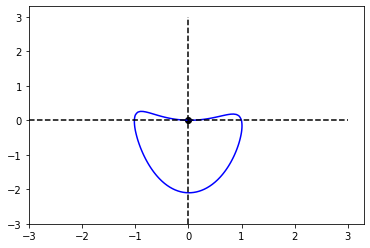

In [39]:
# Plot contour

z_vals = target_distribution_para.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-3,3],color='k',linestyle='dashed')
ax.plot([-3,3],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

To compute the integral, we just need to sample points $p$ from the learned distribution and check if $P(p)>P(0)$

In [40]:
# integrate

n_points = 10000
n_pass = 0

_s = target_distribution_para.sample(n_points)
_v = target_distribution_para.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print(n_pass/n_points)

0.4183


Now lets try another simple example: two 2d gaussians separated in space. This time the distribution is multimodal, so the contour passing through the origin may be more complicated. I have tried this a few times, and the main problem it has is that it just tries to shift the two gaussians, so the inverse map does nothing more than stretch along some axis. You can see the loss function is much higher at the end of the training than for the above case. Bijectors must be smooth functions, so there is a restriction about how the shift can occur (see the notebook "gaussian.ipynb").

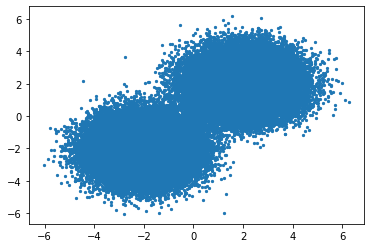

In [41]:
# Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [42]:
## Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

#plt.scatter(X,Y,s=5)

## NN setup
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4,4], activation=tf.math.asinh) # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

#use multiple bijectors, should hopefully get a better result
bijectors=[]
n_bijectors = 3
for i in range(n_bijectors):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
    
target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.Chain(bijectors))#tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 1000
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=80,  # Usually `n // batch_size`.
          validation_split=0.2,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
80/80 [==============================] - 4s 16ms/step - loss: 5.0195 - val_loss: 4.2212
Epoch 2/100
80/80 [==============================] - 1s 9ms/step - loss: 3.8666 - val_loss: 4.2036
Epoch 3/100
80/80 [==============================] - 1s 10ms/step - loss: 3.8312 - val_loss: 4.1816
Epoch 4/100
80/80 [==============================] - 1s 10ms/step - loss: 3.7980 - val_loss: 4.1301
Epoch 5/100
80/80 [==============================] - 1s 8ms/step - loss: 3.7678 - val_loss: 4.0930
Epoch 6/100
80/80 [==============================] - 1s 8ms/step - loss: 3.7479 - val_loss: 4.0563
Epoch 7/100
80/80 [==============================] - 1s 8ms/step - loss: 3.7348 - val_loss: 4.0776
Epoch 8/100
80/80 [==============================] - 1s 7ms/step - loss: 3.7241 - val_loss: 4.0226
Epoch 9/100
80/80 [==============================] - 1s 9ms/step - loss: 3.7155 - val_loss: 4.0236
Epoch 10/100
80/80 [==============================] - 1s 9ms/step - loss: 3.7097 - val_loss: 4.0110
Epoch 

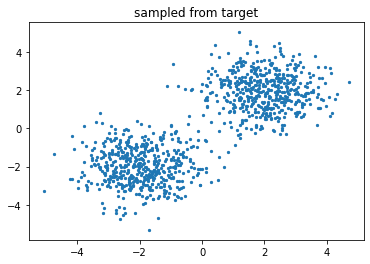

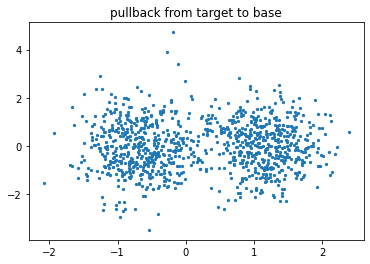

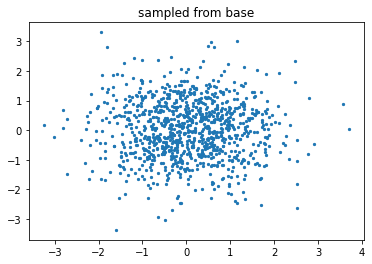

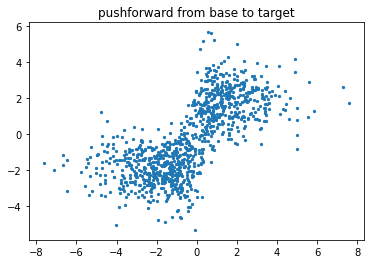

In [43]:
### Check bijector
# resample from target distribution
nsamples=1000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.03007369, shape=(), dtype=float32)
2000
2000
integral =  0.5132


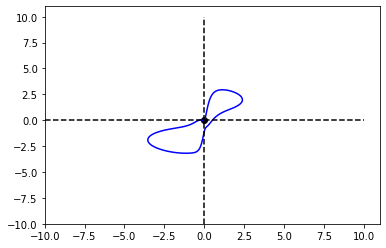

In [44]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

One more example. Lets instead combine the two previous examples!

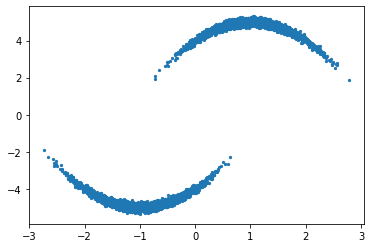

In [45]:
# Create the initial distribution

nsamples=10000
center = 1
stdevx = 0.5
stdevy = 0.1
shifty = 5

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [46]:
## NN setup

# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[8,8], activation=tf.math.asinh) # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 80
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=100,  # Usually `n // batch_size`.
          validation_split=0.2,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 6.3103 - val_loss: 4.8626
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8821 - val_loss: 3.8305
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 3.4265 - val_loss: 3.7472
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3584 - val_loss: 3.7209
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3383 - val_loss: 3.6969
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3196 - val_loss: 3.6912
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2980 - val_loss: 3.7122
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2752 - val_loss: 3.6915
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2487 - val_loss: 3.6815
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2218 - val_lo

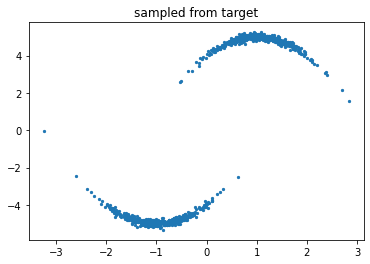

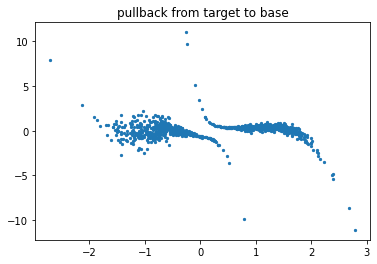

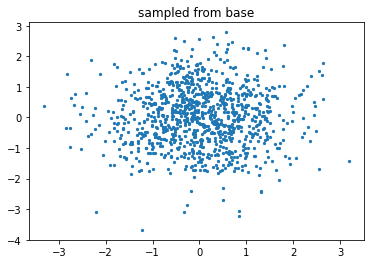

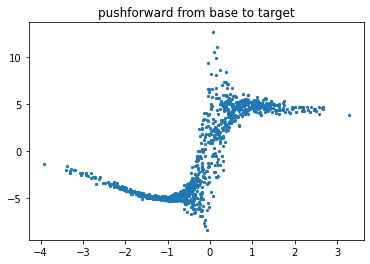

In [47]:
### Check bijector
# resample from target distribution
nsamples=1000

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))


X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.029444806, shape=(), dtype=float32)
2000
2000
integral =  0.8347


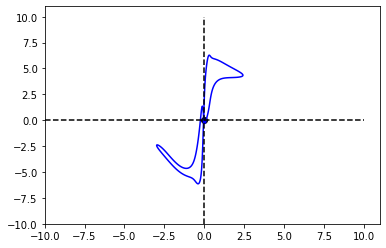

In [48]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

The previous examples show how the power of MAFS falls off for multimodal distributions. This could be fixed with other implementations. For now we can just focus on mono-modal distributions.